In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

find_mini=99999999 ## cost 가 제일적은 값 찾아서 n 대입하려고


In [2]:
# Predict function
def predict(x, infected_data, recovered_data, init, beta, gamma, start, country):
    
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]
        
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
    
    # Extending N days after now
    t_extend = len(x) +20 # N days
    t = np.linspace(0, t_extend, t_extend) #0 + number of dates in data + extended date 
    
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, t_extend], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,t_extend,1))
    
    # Preparing date axis
    date_format = '%m/%d/%y'
    time = start
    for i in range(t_extend-1):
        time_add = datetime.strptime(start, date_format) + timedelta(days=i+1)
        time = np.append(time, time_add.strftime(date_format))
    
    # Adding NaN values of to official data for plotting
    infected_data = np.concatenate((infected_data, [None] * (t_extend-len(infected_data))))
    recovered_data = np.concatenate((recovered_data, [None] * (t_extend-len(recovered_data))))
    
    # Plotting
    df = pd.DataFrame({'Susceptible': res.y[0], 
                        'Infected': res.y[1], 
                        'Recovered': res.y[2], 
                        "Infected (Data)": infected_data, 
                        "Recovered (Data)": recovered_data}, 
                        index=time)
    fig, ax = plt.subplots(figsize = (15,15))
    df['Susceptible'].plot(linestyle = '--', linewidth = 2)
    df['Infected'].plot(linestyle = '--', linewidth = 2)
    df['Recovered'].plot(linestyle = '--', linewidth = 2)
    df['Infected (Data)'].plot(linewidth = 4)
    df['Recovered (Data)'].plot(linewidth = 4)
    plt.ylabel("N", fontsize=18)
    plt.xlabel("month/day/year", fontsize=18)
    plot_title = ('Prediction of COVID-19 in ' + country)
    plt.title(plot_title, fontsize=22)
    plt.legend()
    plt.grid()
    plt.show()
    print(df['Infected']+df['Recovered'])
    return df
    

# Cost function for fitting
def cost(point, infected_data, recovered_data, init):
    
    beta, gamma = point
    global find_mini
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]   
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
   
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, len(infected_data)], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,len(infected_data),1))
  
    # Returns RMSE (Root Mean Square Error) for the function
    rmse_infect = np.sqrt(np.mean((res.y[1] - infected_data)**2)) 
    rmse_recoverd = np.sqrt(np.mean((res.y[2] - recovered_data)**2)) 
    
    # Defining weights
    alpha = 0.1
    find_mini=alpha*rmse_infect + (1-alpha)*rmse_recoverd
    print(alpha*rmse_infect + (1-alpha)*rmse_recoverd)
    return alpha*rmse_infect + (1-alpha)*rmse_recoverd





def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Recovered','Deaths'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Recovered','Deaths']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Recovered','Deaths']]





In [3]:
plt.close()
c_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
r_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
d_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

country = "Korea, South" # input country here
start_date = "1/25/20" # input starting date here

# Parsing confirmed/recovered cases from csv
confirmed = c_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
recovered = r_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)
death = d_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
full_table = confirmed.merge(recovered).merge(death)

full_table

,Province/State,Country/Region,Date,Confirmed,Recovered,Deaths
0,,Afghanistan,1/22/20,0,0,0
1,,Albania,1/22/20,0,0,0
2,,Algeria,1/22/20,0,0,0
3,,Andorra,1/22/20,0,0,0
4,,Angola,1/22/20,0,0,0
...,...,...,...,...,...,...
28723,,Sao Tome and Principe,5/14/20,235,4,7
28724,,Yemen,5/14/20,85,1,12
28725,,Comoros,5/14/20,11,3,1
28726,,Tajikistan,5/14/20,907,0,29


In [4]:
df_m = get_time_series(country)
if len(df_m) > 1 and df_m.iloc[-2,0] >= df_m.iloc[-1,0]:
    df_m.drop(df_m.tail(1).index,inplace=True)
df_m= df_m.sort_values(by="Confirmed")
print(df_m.tail(20))


# Truncate last element to fit recovered data
confirmed = df_m['Confirmed'].values
recovered = df_m['Recovered'].values+df_m['Deaths'].values

print(confirmed)

         Confirmed  Recovered  Deaths
Date                                 
4/25/20      10728       8717     242
4/26/20      10738       8764     243
4/27/20      10752       8854     244
4/28/20      10761       8922     246
4/29/20      10765       9059     247
4/30/20      10774       9072     248
5/1/20       10780       9123     250
5/2/20       10793       9183     250
5/3/20       10801       9217     252
5/4/20       10804       9283     254
5/5/20       10806       9333     255
5/6/20       10810       9419     256
5/7/20       10822       9484     256
5/8/20       10840       9568     256
5/9/20       10874       9610     256
5/10/20      10909       9632     256
5/11/20      10936       9670     258
5/12/20      10962       9695     259
5/13/20      10991       9762     260
5/14/20      11018       9821     260
[    1     1     2     2     3     4     4     4     4    11    12    15
    15    16    19    23    24    24    25    27    28    28    28    28
    28    29    30

In [5]:


# I(t)
infect = confirmed - recovered
real_min= 9999999
real_N=0
################################################################################################################################

for i in range(20):
  i=i*0.1
  # Suceptable
  N = 10591*(1+i)

    #current number of infected * 2.0~ 2.5(R0, Reproductive number of COVID-19)
  # Number of infected at t0
  I0 = 2
  S0 = N-I0
  R0 = 10

  # S(t) = N - I(t) - R(t)
  S = N - confirmed

  # Parameters to optimize

  #Keep working on boundaries.
  optimal = minimize(cost, [0.001, 0.001], args=(infect, recovered, [S0, I0, R0]), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])

  # Prints Beta/Gamma
  print('이게 optimal')
  print(optimal.x)
  print('이게 find_min')
  print(find_mini)
  if find_mini<real_min:
    real_min=find_mini
    real_N=N
################################################################################################################################



5147.110171975764
5147.1102405558
5147.104513051524
5274.480907098014
5274.480580215314
5274.480907098024
6762.058795808117
6762.059858399764
6762.058845007346
5362.2828420847
5362.283837236554
5362.283305155982
3028.873674843769
3028.874357332989
3028.8748012197148
5274.800294433403
5274.796591686834
5274.800294138938
3021.031256488674
3021.0319894915333
3021.0323790108923
2849.7322303022793
2849.734429222883
2849.733223670817
2846.564584735409
2846.5668637406297
2846.565575045077
2843.397636103239
2843.399989691651
2843.398623341702
2697.247669688345
2697.255807263361
2697.24848978046
2693.872879759856
2693.881258310595
2693.873695622694
2690.450711297195
2690.459330507981
2690.4515228605514
2488.787805710154
2488.8194988896557
2488.788336307585
2481.110532271296
2481.143456217358
2481.1110509607643
2473.227815251719
2473.262020671456
2473.2283216032956
2145.468565054143
2145.572597559156
2145.468418321782
2145.468565054143
2145.572597559156
2145.468418321782
5274.787386284372
5274.7

2734.2816050230213
2734.281607125942
2734.2816030255026
2734.2797384847368
2734.2797405909578
2734.2797343039038
2734.2713693766345
2734.271371507861
2734.271358944228
2734.2520771264826
2734.2520793323197
2734.252057685492
2734.191118750767
2734.1911212479745
2734.191080756655
2733.902945269538
2733.9029497612864
2733.9028544827297
5275.006200775479
5275.002330892441
5275.006200287814
2733.9028583701934
2733.902862862674
2733.902767570204
2732.606109730933
2732.606126630485
2732.6059361505786
2732.605352816108
2732.6053697234192
2732.6051792121243
2732.604595385409
2732.6046123005417
2732.604421757782
2728.990746353813
2728.9908115687203
2728.990507893402
2728.9865038353414
2728.986569124975
2728.9862653227297
2728.9822554639495
2728.982320828402
2728.982016899095
2712.707225955046
2712.707750539499
2712.706905401701
2712.707225955046
2712.707750539499
2712.706905401701
5274.995033746543
5274.991124418424
5274.9950332692815
2712.590989409331
2712.5915108652553
2712.590669016635
2681.9

618.3513675871085
618.3513683199972
618.4398608021122
618.3513675870212
618.3513683199859
618.439860802114
618.3513675870023
618.3513683199856
618.4398608021115
618.3513675870045
618.3513683199844
618.4398608021141
618.3513675870039
618.3513683199827
618.4398608021122
618.3513675870015
618.3513683199827
618.4398608021122
618.3513675870015
618.3513683199845
618.4398608021149
618.3513675870064
618.3513683199827
618.4398608021122
618.3513675870015
5274.480809032857
5274.480383965497
5274.48080903287
636.7112382047226
637.5100690637055
636.7114232583091
618.4515132625986
618.4662207504539
618.4515175311403
618.3514037499947
618.4403335246841
618.3514031233163
618.3513743751887
618.4399488269526
618.351373662135
618.3513694393848
618.4398773546279
618.3513687101571
618.3513685301843
618.4398639204529
618.3513677979126
618.3513683595726
618.4398613897828
618.3513676267255
618.351368327446
618.4398609128696
618.3513675944859
618.3513683213877
618.4398608229858
618.3513675884132
618.3513683202

2932.033409039227
2932.0331572027353
2932.032691702333
2932.032709780038
2932.0324578976456
2932.0319919527897
2932.0320100388226
2932.031758110431
2928.6622552344083
2928.6623240943527
2928.661922255578
2928.65819142872
2928.6582603641505
2928.6578583708506
2928.6541224331777
2928.6541914441996
2928.6537892962187
2914.548400968127
2914.5492032871007
2914.5479515877805
2914.382551909369
2914.383354581825
2914.382101787735
2914.217781244525
2914.2185838875303
2914.217330382632
2887.949212564146
2887.9513058673515
2887.9485711578245
2887.949212564146
2887.9513058673515
2887.9485711578245
5275.100047748731
5275.09565283916
5275.100047172072
2887.657344265384
2887.6594430870346
2887.656701437855
2836.553461934526
2836.559916114552
2836.552485595532
2835.905130489534
2835.9116556048257
2835.904149556987
2835.251703523102
2835.2582974805064
2835.2507179471713
2751.120251045044
2751.139273847508
2751.1185621349905
2749.8252661081237
2749.8444994656747
2749.8235644353026
2748.5266248876856
274

5274.752855510982
5274.7468251425935
5274.752855257853
1602.0657738126988
1603.2360539317028
1602.0659719314294
3005.265736300508
2998.758163398732
3005.2645600057895
1341.9233751886288
1342.6846011580728
1341.922567420419
1297.4137967301149
1296.141962048161
1297.4117685876704
5274.480710952114
5274.480187653273
5274.48071095213
5207.574447241027
5206.810317452606
5207.574487026148
2422.2375410831
2428.287561877222
2422.237727104188
1348.125686996445
1351.8468308033193
1348.126850812169
1004.0491468501862
1005.5850672246536
1004.049253552162
5274.5419254871895
5274.536561398438
5274.541925427574
922.6276716933079
922.8448559411323
922.6274365838931
5274.480710952114
5274.480187653273
5274.48071095213
2835.7583456545904
2822.4635476051462
2835.7590071191075
1936.7509692327792
1942.053429690999
1936.7513762644992
935.8751836752792
937.5565752261443
935.8756499056387
918.2018373079316
918.9208786766053
918.2018584664552
5274.480710952114
5274.480187653273
5274.48071095213
950.51095137328

3179.8611131010784
3179.845707786288
3179.845712085014
3179.8457302974057
3179.7984871643785
3179.7984918508937
3179.7985379515058
3179.6372853196804
3179.6372916365917
3179.637396663318
5275.145596017697
5275.140600805734
5275.145595396958
3179.6372840559384
3179.637290373019
3179.637395407443
3179.8425584506986
3179.842586565942
3179.842970844318
3179.636777226392
3179.6367836418717
3179.6368930328963
5275.151976977932
5275.14702336845
5275.151976351211
3179.6365997304024
3179.6366061478457
3179.6367155853304
3178.0894074785338
3178.089434622596
3178.0896747894353
3178.087919674035
3178.0879468389476
3178.0881870305284
3178.0864300685007
3178.0864572543483
3178.086697470575
3173.307515807136
3173.3076263004386
3173.3078152567805
3173.298072049586
3173.2981827442027
3173.2983714768643
3173.288608600838
3173.2887194973173
3173.288908005563
3155.059944088147
3155.0611120275066
3155.060170545719
3154.771710613666
3154.7728806420882
3154.7719360937826
3154.485438567959
3154.48660950449
31

1942.6314132737411
1944.1143662475733
1942.6324431437233
5274.827214489237
5274.820235712156
5274.827214164988
1776.4962336640078
1778.0870368587175
1776.4968352899023
3247.1389246081917
3239.5108885629456
3247.1374003895044
1510.9567320754668
1512.019357927768
1510.9560010504783
1464.806142353078
1463.2271462659944
1464.8036488507864
5274.480612855784
5274.479991278613
5274.480612855801
5218.78464338104
5218.043096808982
5218.784675751617
3603.6270244785787
3612.6919576551754
3603.6271851701904
1982.6390037563297
1987.5124671400936
1982.640751517933
1245.5459133927377
1247.1531334145152
1245.546180849274
5274.599642204699
5274.592685515785
5274.599642091412
1191.8499419823738
1192.2397690891196
1191.8498593420684
5274.480612855784
5274.479991278613
5274.480612855801
2797.79476034009
2808.243019680074
2797.7945537539404
1240.5623495422615
1242.8997273591278
1240.5633576171588
1191.532088763207
1192.0760984627473
1191.5321019918342
5274.479127266099
5274.477280722782
5274.479127266283
1

1275.8661460840706
1275.8760219298088
1275.866140682578
1275.8878387824698
1275.8879878571456
1275.8878389413549
1275.8674696506264
1275.8763719295614
1275.8674648208362
1275.8662862950418
1275.876051819257
1275.866280958507
1275.8661620583657
1275.8760252349311
1275.8661566643336
1275.8661479196508
1275.8760223082606
1275.8661425190155
1275.8661462952018
1275.8760219733208
1275.8661408938078
1275.8661461083577
1275.8760219348133
1275.8661407068764
1275.8661460868648
1275.8760219303842
1275.8661406853728
1275.8661460843919
1275.8760219298745
1275.8661406828985
1275.8661460841076
1275.876021929816
1275.8661406826145
1275.8661460840747
1275.876021929809
1275.8661406825815
1275.8661460840708
1275.876021929809
1275.8661406825781
1275.8661460840704
1275.8760219298088
1275.8661406825781
1275.8661460840708
1275.8760219298094
1275.866140682578
1275.8661460840704
1275.8760219298088
1275.8661406825781
1275.8661460840704
1275.8760219298088
1275.8661406825781
1275.866146084071
1275.8760219298088
1

2507.7107388911836
2506.9327964401145
5275.019817304086
5275.012766463686
5275.019816799233
2417.839852355519
2418.6699607272903
2417.839801783213
2791.8926346062945
2787.161335011554
2791.8886370019827
2121.5990169649704
2122.025622563198
2121.596503537663
5274.48051474386
5274.479794841489
5274.48051474388
3497.0186784012803
3477.0631999063653
3497.019465205254
7659.672466122646
7669.196020039943
7659.67252866501
4179.275593614446
4183.325736023756
4179.2784884197645
2050.7940885209964
2052.795587246905
2050.795391148057
5274.851295609745
5274.843294762876
5274.851295261946
1866.9285977951959
1869.0296038684153
1866.9293730165193
3664.633521066157
3655.485933940776
3664.63203410104
1654.1742999013693
1655.5187374267582
1654.173757143494
1604.1838237761021
1602.45852390162
1604.181343510308
5274.48051474386
5274.479794841489
5274.48051474388
5224.354393601417
5223.589480553217
5224.354422317989
4671.516212188988
4684.238167728434
4671.516384347162
2478.703773532959
2484.772761024954
2

1542.294545899919
1542.2446286817822
1542.244619929892
1542.2945473306847
1542.244628548534
1542.2446199042654
1542.2945476053478
1542.2446285229623
1542.244619899347
1542.2945476580744
1542.244628518053
1542.2446198984028
1542.2945476681957
1542.2446285171113
1542.244619898222
1542.294547670138
1542.2446285169297
1542.2446198981866
1542.2945476705108
1542.2446285168955
1542.2446198981797
1542.294547670583
1542.244628516889
1542.2446198981784
1542.2945476705972
1542.244628516888
1542.2446198981793
1542.2945476705877
1542.2446285168885
1542.2446198981788
1542.294547670595
1542.244628516888
1542.2446198981784
1542.2945476705959
1542.2446285168876
1542.2446198981788
1542.2945476705963
1542.2446285168874
1542.2446198981784
1542.2945476705959
1542.2446285168876
이게 optimal
[8.62898054e-06 9.76816053e-03]
이게 find_min
1542.2446285168876
5769.569405185677
5769.569350858321
5769.55624100275
19750.750053898402
19750.750053895725
19750.750063026604
18921.627844152863
18921.627844167386
18921.62794

689.9309373992753
693.3735526525845
693.373399905808
689.9309373956368
693.3735526522671
693.3733999057299
689.930937394877
693.3735526522122
693.3733999057176
689.9309373947199
693.3735526521925
693.373399905734
689.9309373947513
693.3735526522103
693.373399905716
689.9309373947251
693.3735526522139
693.3733999057166
689.9309373947307
693.3735526521966
7304.770942632124
7304.770942631834
7304.754877740994
20484.808050404266
20484.808050412652
20484.808072171378
20628.159501684604
20628.159501812832
20628.15951363656
20659.683129280224
20659.68313039751
20659.683139411318
20665.95090640052
20665.950916653655
20665.950916015434
20658.570741014755
20658.57083703415
20658.570750450566
20626.980537073363
20626.982010017466
20626.980546497663
20359.72917920445
20359.755599129017
20359.729187338133
17405.10510356557
17406.875534040384
17405.10496675321
3728.1545240727687
3746.5079826333194
3728.1537459097062
699.0765567235861
705.2080848188723
699.0763306998065
687.0921077049348
687.86450610

1802.101576195323
1802.101576192322
1802.1015843164419
1802.1015761947742
1802.101576192322
1802.1015843164419
1802.1015761947742
1802.1015761925964
1802.1015843158625
1802.101576195048
1802.1015761923215
1802.101584316442
1802.1015761947742
1802.1015761923218
1802.1015843164414
1802.101576194775
1802.1015761923215
1802.101584316442
1802.1015761947742
1802.1015761923215
1802.101584316442
1802.1015761947742
1802.1015761923225
1802.1015843164414
1802.1015761947751
1802.1015761923215
1802.101584316442
1802.1015761947742
1802.1015761923215
1802.101584316442
1802.1015761947742
1802.1015761923225
1802.1015843164414
1802.1015761947751
1802.1015761923215
1802.101584316442
1802.1015761947742
이게 optimal
[7.69138782e-06 8.33835059e-03]
이게 find_min
1802.1015761947742
5911.631723316991
5911.631669826176
5911.617098852394
22530.01121873062
22530.011218736352
22530.011228595227
21621.295674524565
21621.295674536465
21621.295785928225
17875.534589130748
17875.534589436
17875.536006908304
8633.85691461

4123.277055376169
5275.3040294310695
5275.297941227617
5275.304028656361
4123.276942353283
4123.2769581589355
4123.2766007117
4121.540353413317
4121.540411799396
4121.5396555337165
4121.5373023877455
4121.537360854966
4121.536604191334
4121.534245223184
4121.534303772308
4121.5335467097175
4116.710265793186
4116.710514587716
4116.70927663295
4116.689138899896
4116.689389309597
4116.6881489364305
4116.667790366568
4116.668042422945
4116.666799595214
4089.8968531433106
4089.8978622262025
4089.8954834420983
4089.8968531433106
4089.8978622262025
4089.8954834420983
5275.30075697386
5275.2946308783
5275.300756202237
4089.7573775083356
4089.7583905255115
4089.7560067374156
4045.8259193578697
4045.8322992199282
4045.8241154344228
4044.8297581943907
4044.836430390853
4044.8279420884114
4043.770080360524
4043.7770580097995
4043.7682514922208
3961.002099215545
3961.0254435726083
3960.9990999844304
3958.2555068234165
3958.2795726398426
3958.2524632429518
3955.4516223998585
3955.4764120028517
3955.

2057.263969281357
2057.263967436609
2057.266659838388
2057.263969172583
2057.2639674353177
2057.2666598411774
2057.2639691712943
2057.2639674353027
2057.2666598412097
2057.26396917128
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.263967435302
2057.2666598412097
2057.2639691712793
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.263967435302
2057.2666598412097
2057.263969171279
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.2639674353018
2057.2666598412106
2057.2639691712793
2057.2639674353018
2057.26665984121
2057.2639691712798
2057.2639674353018
2057.26665984121
2057.2639691712798
2057.2639674353018
2057.26665984121
2057.2639691712798
2057.263967435302
2057.26665984121
2057.2639691712784
2057.2639674353018
2057.26665984121
2057.2639691712798
2057.2639674353018
2057.26665984121
2057.2639691712798
5275.567166298019
5275.56425451340

5188.45622730353
5188.4562424213
5188.450003346752
5274.480874411361
5274.48051480564
5274.480874411371
7554.3604098267315
7554.361539476676
7554.360462432079
6018.678048079993
6018.679015090242
6018.678563603687
3240.642521737519
3240.6431278808172
3240.643993281596
5274.831932718235
5274.827925102532
5274.831932392764
3225.7903185997657
3225.7910076473677
3225.79178582903
2998.228872250169
2998.2310342472374
2998.2302160156714
2993.1510766049073
2993.1533623768273
2993.152416246151
2988.0794887967577
2988.081904375018
2988.0808242814664
2811.9486201075156
2811.9572836086854
2811.9497775150385
2807.3970386028845
2807.40601251326
2807.398190662342
2802.783305518924
2802.792607398105
2802.784452135116
2577.6419593336227
2577.676898567341
2577.6428068336104
2568.0628734798674
2568.099383191656
2568.063706668831
2558.1982826352432
2558.2364617502217
2558.199100934072
2188.7152516513506
2188.8395260352463
2188.715360844366
2188.7152516513506
2188.8395260352463
2188.715360844366
5274.833701

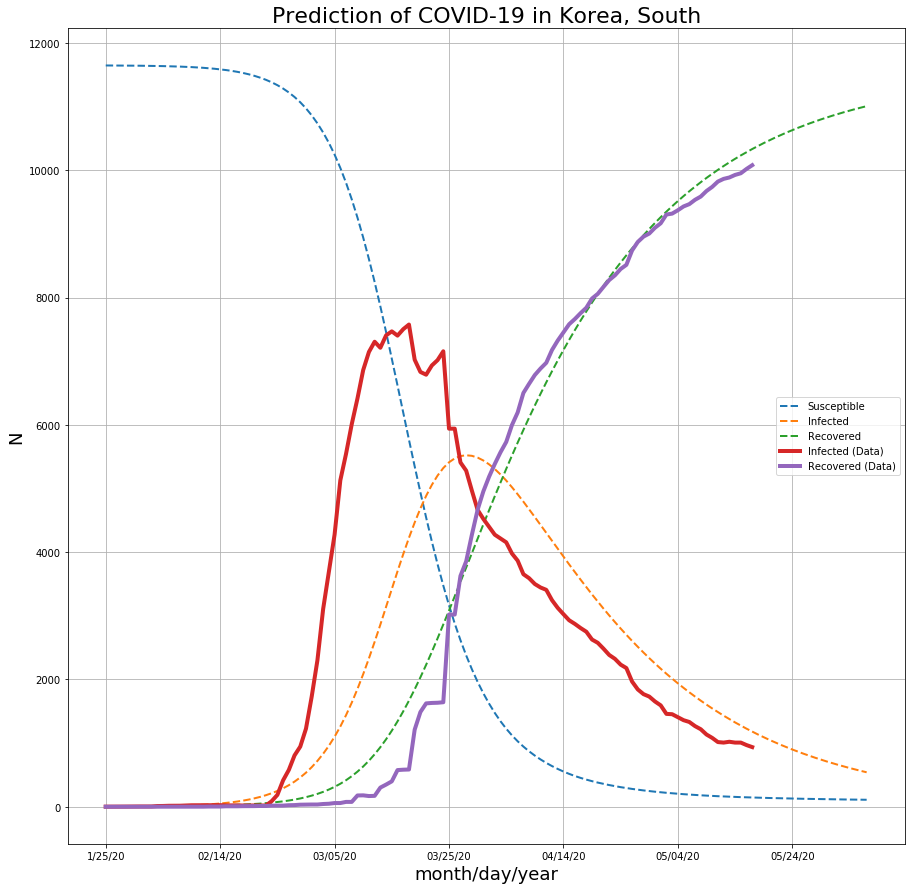

1/25/20        12.000000
01/26/20       12.440545
01/27/20       12.958477
01/28/20       13.567618
01/29/20       14.283204
                ...     
06/02/20    11545.908823
06/03/20    11547.136129
06/04/20    11548.303974
06/05/20    11549.415821
06/06/20    11550.474860
Length: 134, dtype: float64


In [9]:
N = real_N #current number of infected * 2.0~ 2.5(R0, Reproductive number of COVID-19)
# Number of infected at t0
I0 = 2
S0 = N-I0
R0 = 10

# S(t) = N - I(t) - R(t)
S = N - confirmed

# Parameters to optimize

#Keep working on boundaries.
optimal = minimize(cost, [0.001, 0.001], args=(infect, recovered, [S0, I0, R0]), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])

# Prints Beta/Gamma
print('이게 optimal')
print(optimal.x)

 ################################################################################################################### 
# Prints Gamma/Beta, if S0 > Gamma/Beta -> exponential growth
print("Gamma/Beta: " + str(optimal.x[1]/optimal.x[0]))

# Prints Repoductive Ratio S0*Beta/Gamma.
print("S0*Beta/Gamma: " + str(S0*optimal.x[0]/optimal.x[1]))
print("S0 : " +str(S0))

# Predicting numbers from optimized gamma & beta
t = np.linspace(0,len(infect), len(infect))
df = predict(np.transpose(t), infect, recovered, [S0, I0, R0], optimal.x[0], optimal.x[1], start_date, country)

In [7]:
print(df.tail(30))

          Susceptible     Infected     Recovered Infected (Data)  \
05/08/20   179.630856  1667.123854   9813.345290            1218   
05/09/20   174.572538  1604.882083   9880.645379            1135   
05/10/20   169.870682  1544.812949   9945.416369            1082   
05/11/20   165.500373  1486.855398  10007.744229            1016   
05/12/20   161.437296  1430.949307  10067.713397            1008   
05/13/20   157.657739  1377.035487  10125.406774            1021   
05/14/20   154.138589  1325.055678  10180.905733            1008   
05/15/20   150.857338  1274.952553  10234.290109            1008   
05/16/20   147.792075  1226.669716  10285.638209             969   
05/17/20   144.921496  1180.151701  10335.026803             937   
05/18/20   142.224893  1135.343977  10382.531131            None   
05/19/20   139.682163  1092.192939  10428.224898            None   
05/20/20   137.273804  1050.645919  10472.180277            None   
05/21/20   134.980914  1010.651177  10514.467909

In [8]:
name = "./" + country + " predict.csv"
df.to_csv(name)